# ShowUI-2B Tutorial: Multimodal Analysis with FiftyOne

This tutorial demonstrates how to use the ShowUI-2b vision-language models with FiftyOne as a vision-language-action model designed for GUI agents.

## 1. Load a Sample Dataset

First, let's load a small UI dataset from the FiftyOne Dataset Zoo.

You can see some other GUI grounding datasets [here](https://huggingface.co/datasets?other=gui-grounding)

In [1]:
import fiftyone as fo
from fiftyone.utils.huggingface import load_from_hub

# Load 5 random samples from the GUI Act dataset
dataset = load_from_hub(
    "Voxel51/GroundUI-18k",
    max_samples=200,
    shuffle=True,
    overwrite=True
)

Loading dataset
Importing samples...
 100% |█████████████████| 200/200 [5.9ms elapsed, 0s remaining, 34.1K samples/s]       


100%|██████████| 1/1 [00:04<00:00,  4.23s/it]


To get an idea of what is in this dataset you can launch the FiftyOne App to visualize it:


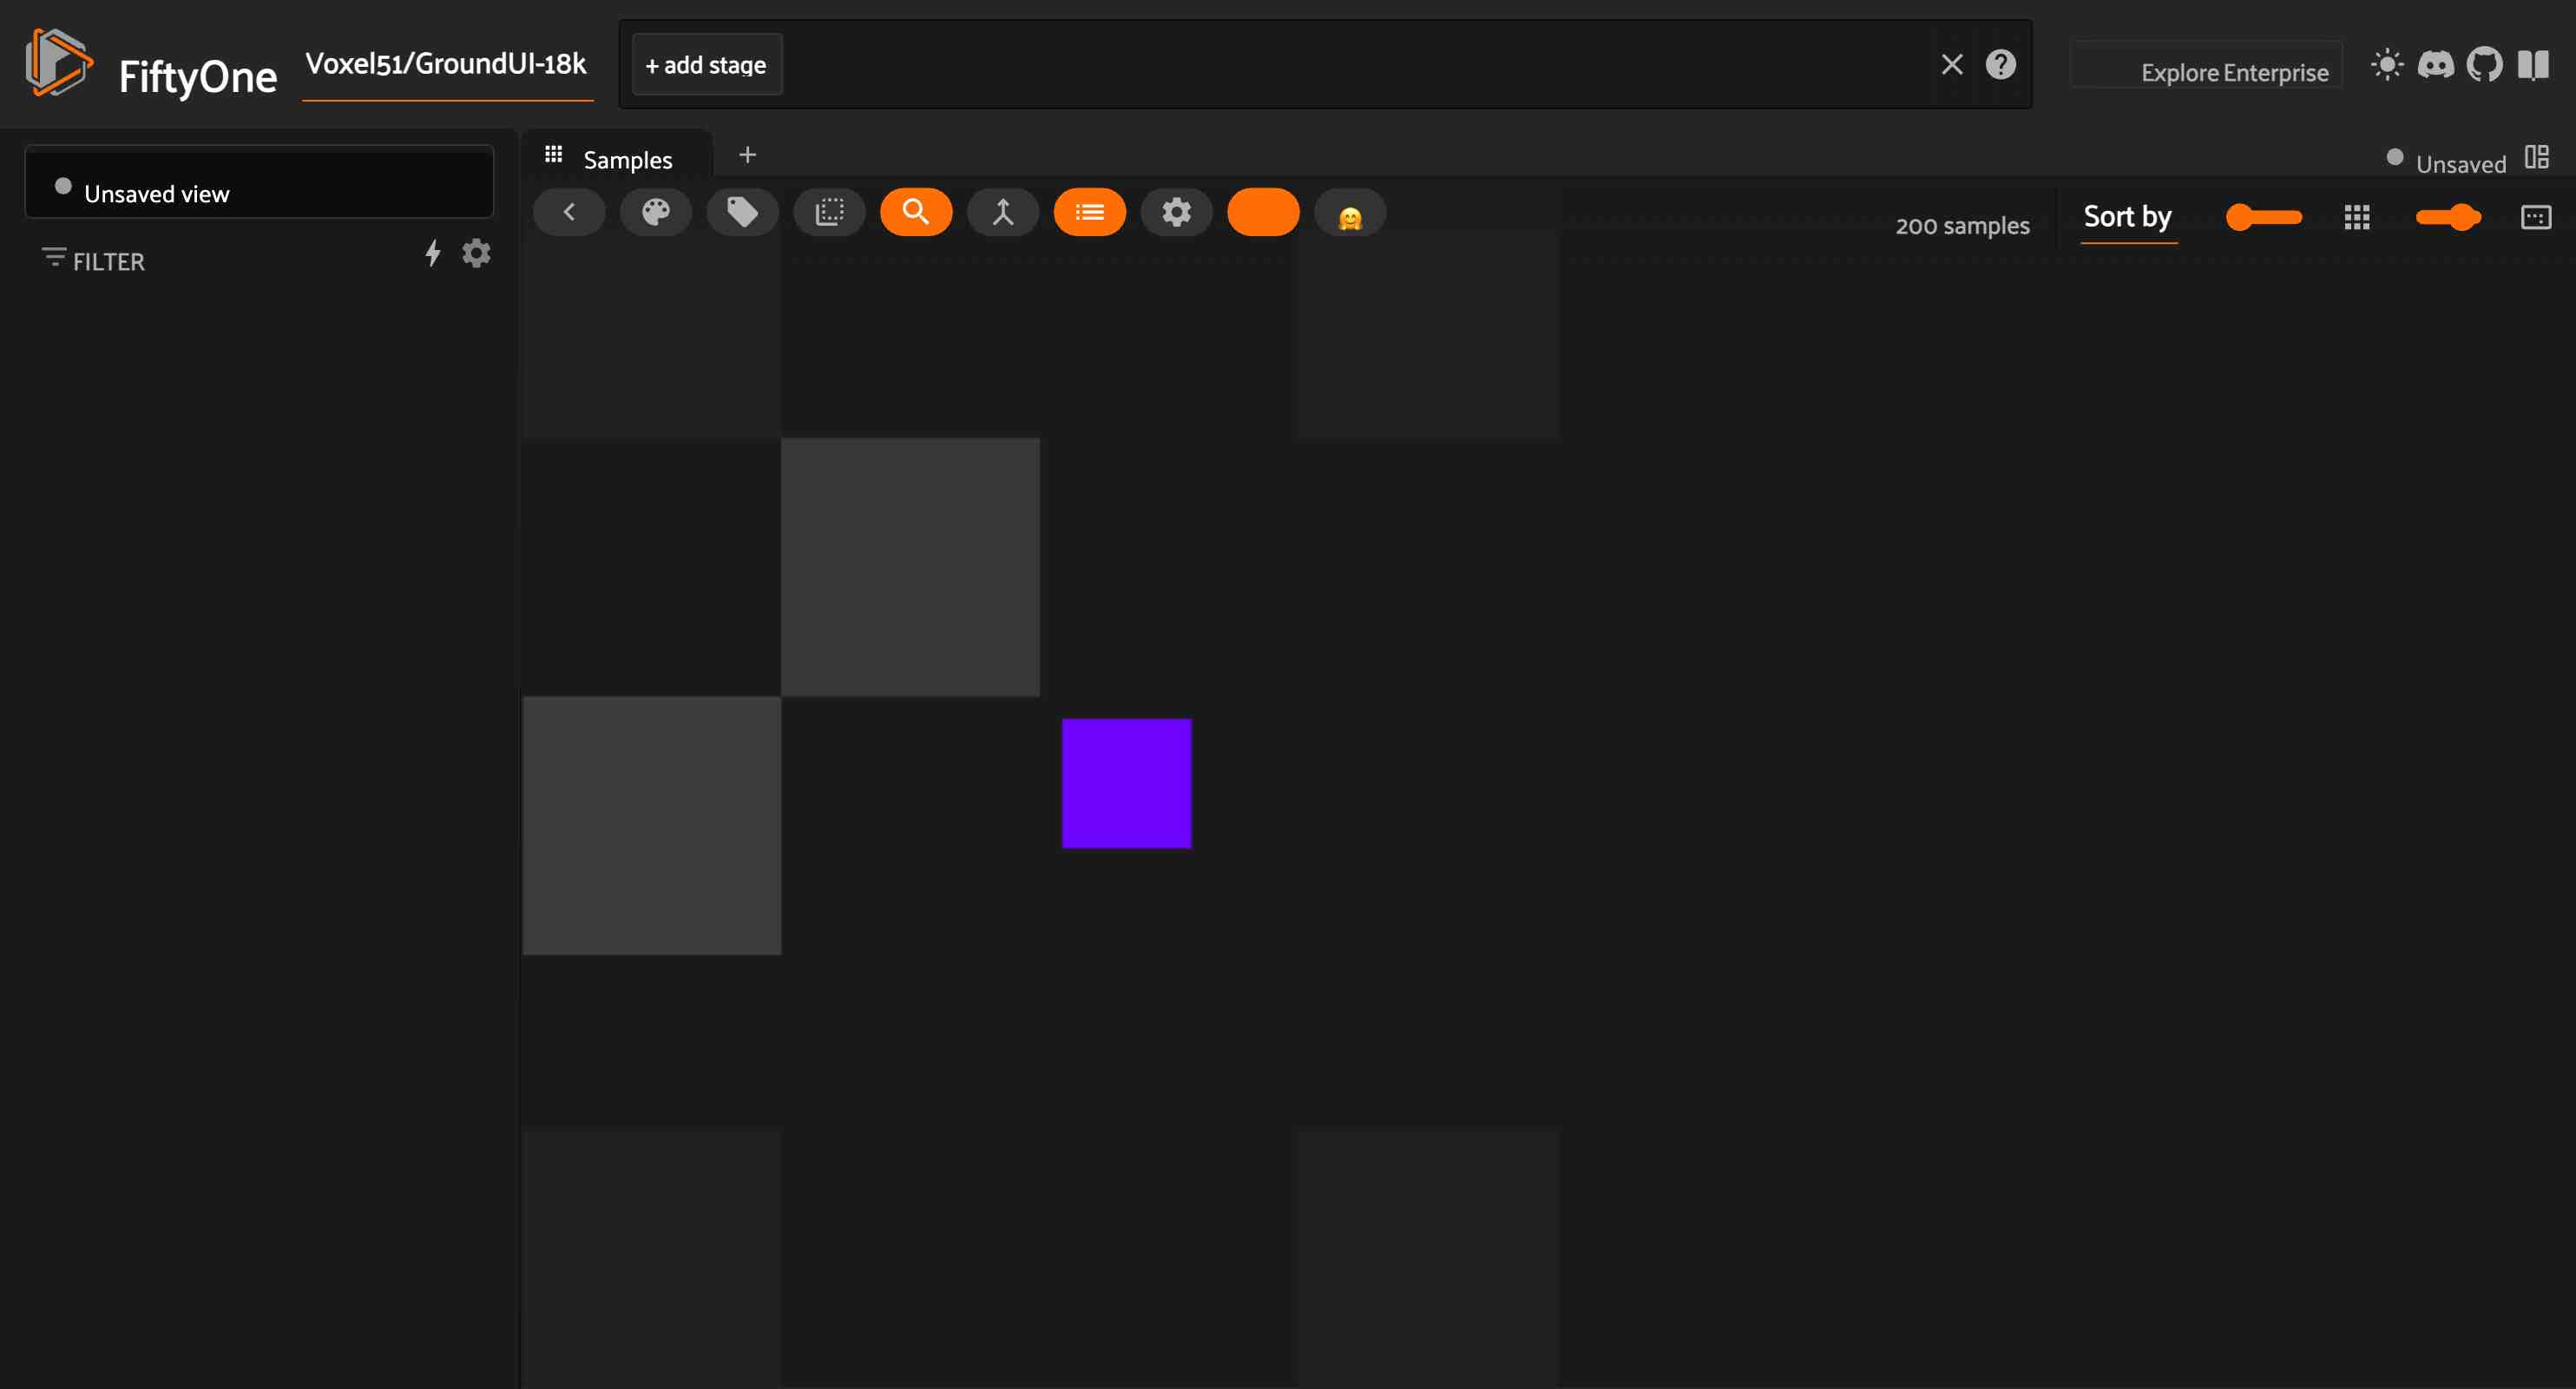

Dataset:          Voxel51/GroundUI-18k
Media type:       image
Num samples:      200
Selected samples: 0
Selected labels:  0
Session URL:      http://localhost:5151/

In [2]:
fo.launch_app(dataset)

Or just look at the first sample:

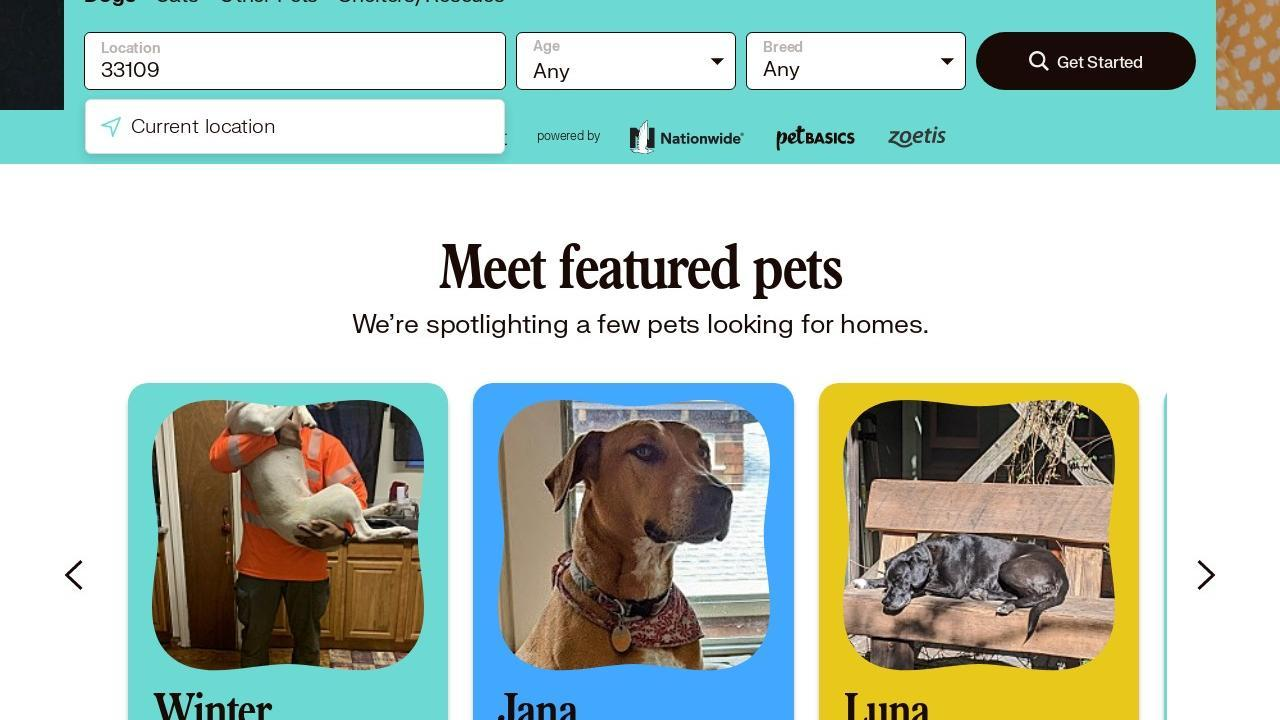

In [3]:
from PIL import Image

Image.open(dataset.first().filepath)

In [4]:
dataset.first().instruction

'Click on "Get Started".'

## 2. Set Up ShowUI Integration

Register the ShowUI remote zoo model source and load the model.

In [5]:
import fiftyone.zoo as foz

# Register the model source
foz.register_zoo_model_source("https://github.com/harpreetsahota204/ShowUI", overwrite=True)

  118.0Kb [45.9ms elapsed, ? remaining, 2.6Mb/s] 
Overwriting existing model source '/home/harpreet/fiftyone/__models__/ShowUI'


# Load the `ShowUI-2B` model


In [ ]:
model = foz.load_zoo_model(
    "showlab/ShowUI-2B",
    quantized=True #only for GPU
    # install_requirements=True, #you can pass this to make sure you have all reqs installed
    )

Note that for any of the following operations you can use a Field which currently exists on your dataset, all you need to do is pass the name of that field in `prompt_field` when you call `apply_model`. For example:

```python
dataset.apply_model(model, prompt_field="<field-name>", label_field="<label-field>")
```

Alternatively, you can run a single prompt across all samples like so:

```python
model.prompt = "Locate the elements of this UI that a user can interact with."
dataset.apply_model(model, label_field="one_prompt")
```

## 1. Simple UI Grounding

Ask the model to ground an element in a screenshots with a keypoint.

In [7]:
model.operation = "simple_grounding"

The prompt for this operation is:

In [8]:
print(model.system_prompt)

Based on the screenshot of the page, I give a text description and you give its corresponding location. The coordinate represents a clickable location [x, y] for an element, which is a relative coordinate on the screenshot, scaled from 0 to 1.


In [9]:
dataset.apply_model(
    model, 
    prompt_field="instruction", # use a field from the dataset
    label_field="simple_grounding_kps"
    )

 100% |█████████████████| 200/200 [2.0m elapsed, 0s remaining, 1.7 samples/s]      


## 2. Action Grounding

Action grounding is the process of translating high-level task instructions into precise, executable UI actions with specific coordinates and parameters based on visual screen observations.

In this case we are prompting the model to format the action as a dictionary with the following keys:
`{'action': 'ACTION_TYPE', 'value': 'element', 'position': [x,y]}`

In [10]:
model.operation = "action_grounding"

The prompt for this operation is:

In [11]:
print(model.system_prompt)

You are an assistant trained to navigate the web screen and the phone screen. 
Given a task instruction and a screen observation, you output the next action. Choose the correct action for the web screen or the phone screen. 

Here is the action space:
1. `CLICK`: Click on an element in the web screen, value is not applicable and the position [x,y] is required. 
2. `INPUT`: Type a string into an element, value is a string to type and the position [x,y] is required. 
3. `SELECT`: Select a value for an element, value is not applicable and the position [x,y] is required. 
4. `HOVER`: Hover on an element, value is not applicable and the position [x,y] is required.
5. `ANSWER`: Answer the question, value is the answer and the position is not applicable.
6. `ENTER`: Enter operation, value and position are not applicable.
7. `SCROLL`: Scroll the screen, value is the direction to scroll and the position is not applicable.
8. `SELECT_TEXT`: Select some text content, value is not applicable and p

In [12]:
dataset.apply_model(
    model, 
    prompt_field="instruction", # use a field from the dataset
    label_field="action_grounding_kp",
    )


 100% |█████████████████| 200/200 [3.4m elapsed, 0s remaining, 1.0 samples/s]      


## 9. View Results

Examine the results for the first sample.

In [13]:
dataset.first()

<Sample: {
    'id': '681298eadd45a1f1b79d01c9',
    'media_type': 'image',
    'filepath': '/home/harpreet/fiftyone/huggingface/hub/Voxel51/GroundUI-18k/data/data_0/image_0.png',
    'tags': ['train'],
    'metadata': <ImageMetadata: {
        'size_bytes': 100761,
        'mime_type': 'image/png',
        'width': 1280,
        'height': 720,
        'num_channels': 3,
    }>,
    'created_at': datetime.datetime(2025, 6, 26, 19, 30, 22, 183000),
    'last_modified_at': datetime.datetime(2025, 6, 26, 19, 32, 41, 999000),
    'image_path': '44531ae3-cdad-437b-b19a-fcc8f04b7656-8c1a6b4e-8f68-479c-b84d-93684a64d92d.jpg',
    'instruction': 'Click on "Get Started".',
    'source': 'mind2web_test_domain',
    'platform': 'web',
    'detections': <Detection: {
        'id': '6812a354dd45a1f1b79d4836',
        'attributes': {},
        'tags': [],
        'label': 'grounding_element',
        'bounding_box': [
            0.7625,
            0.044444444444444446,
            0.171875,
      


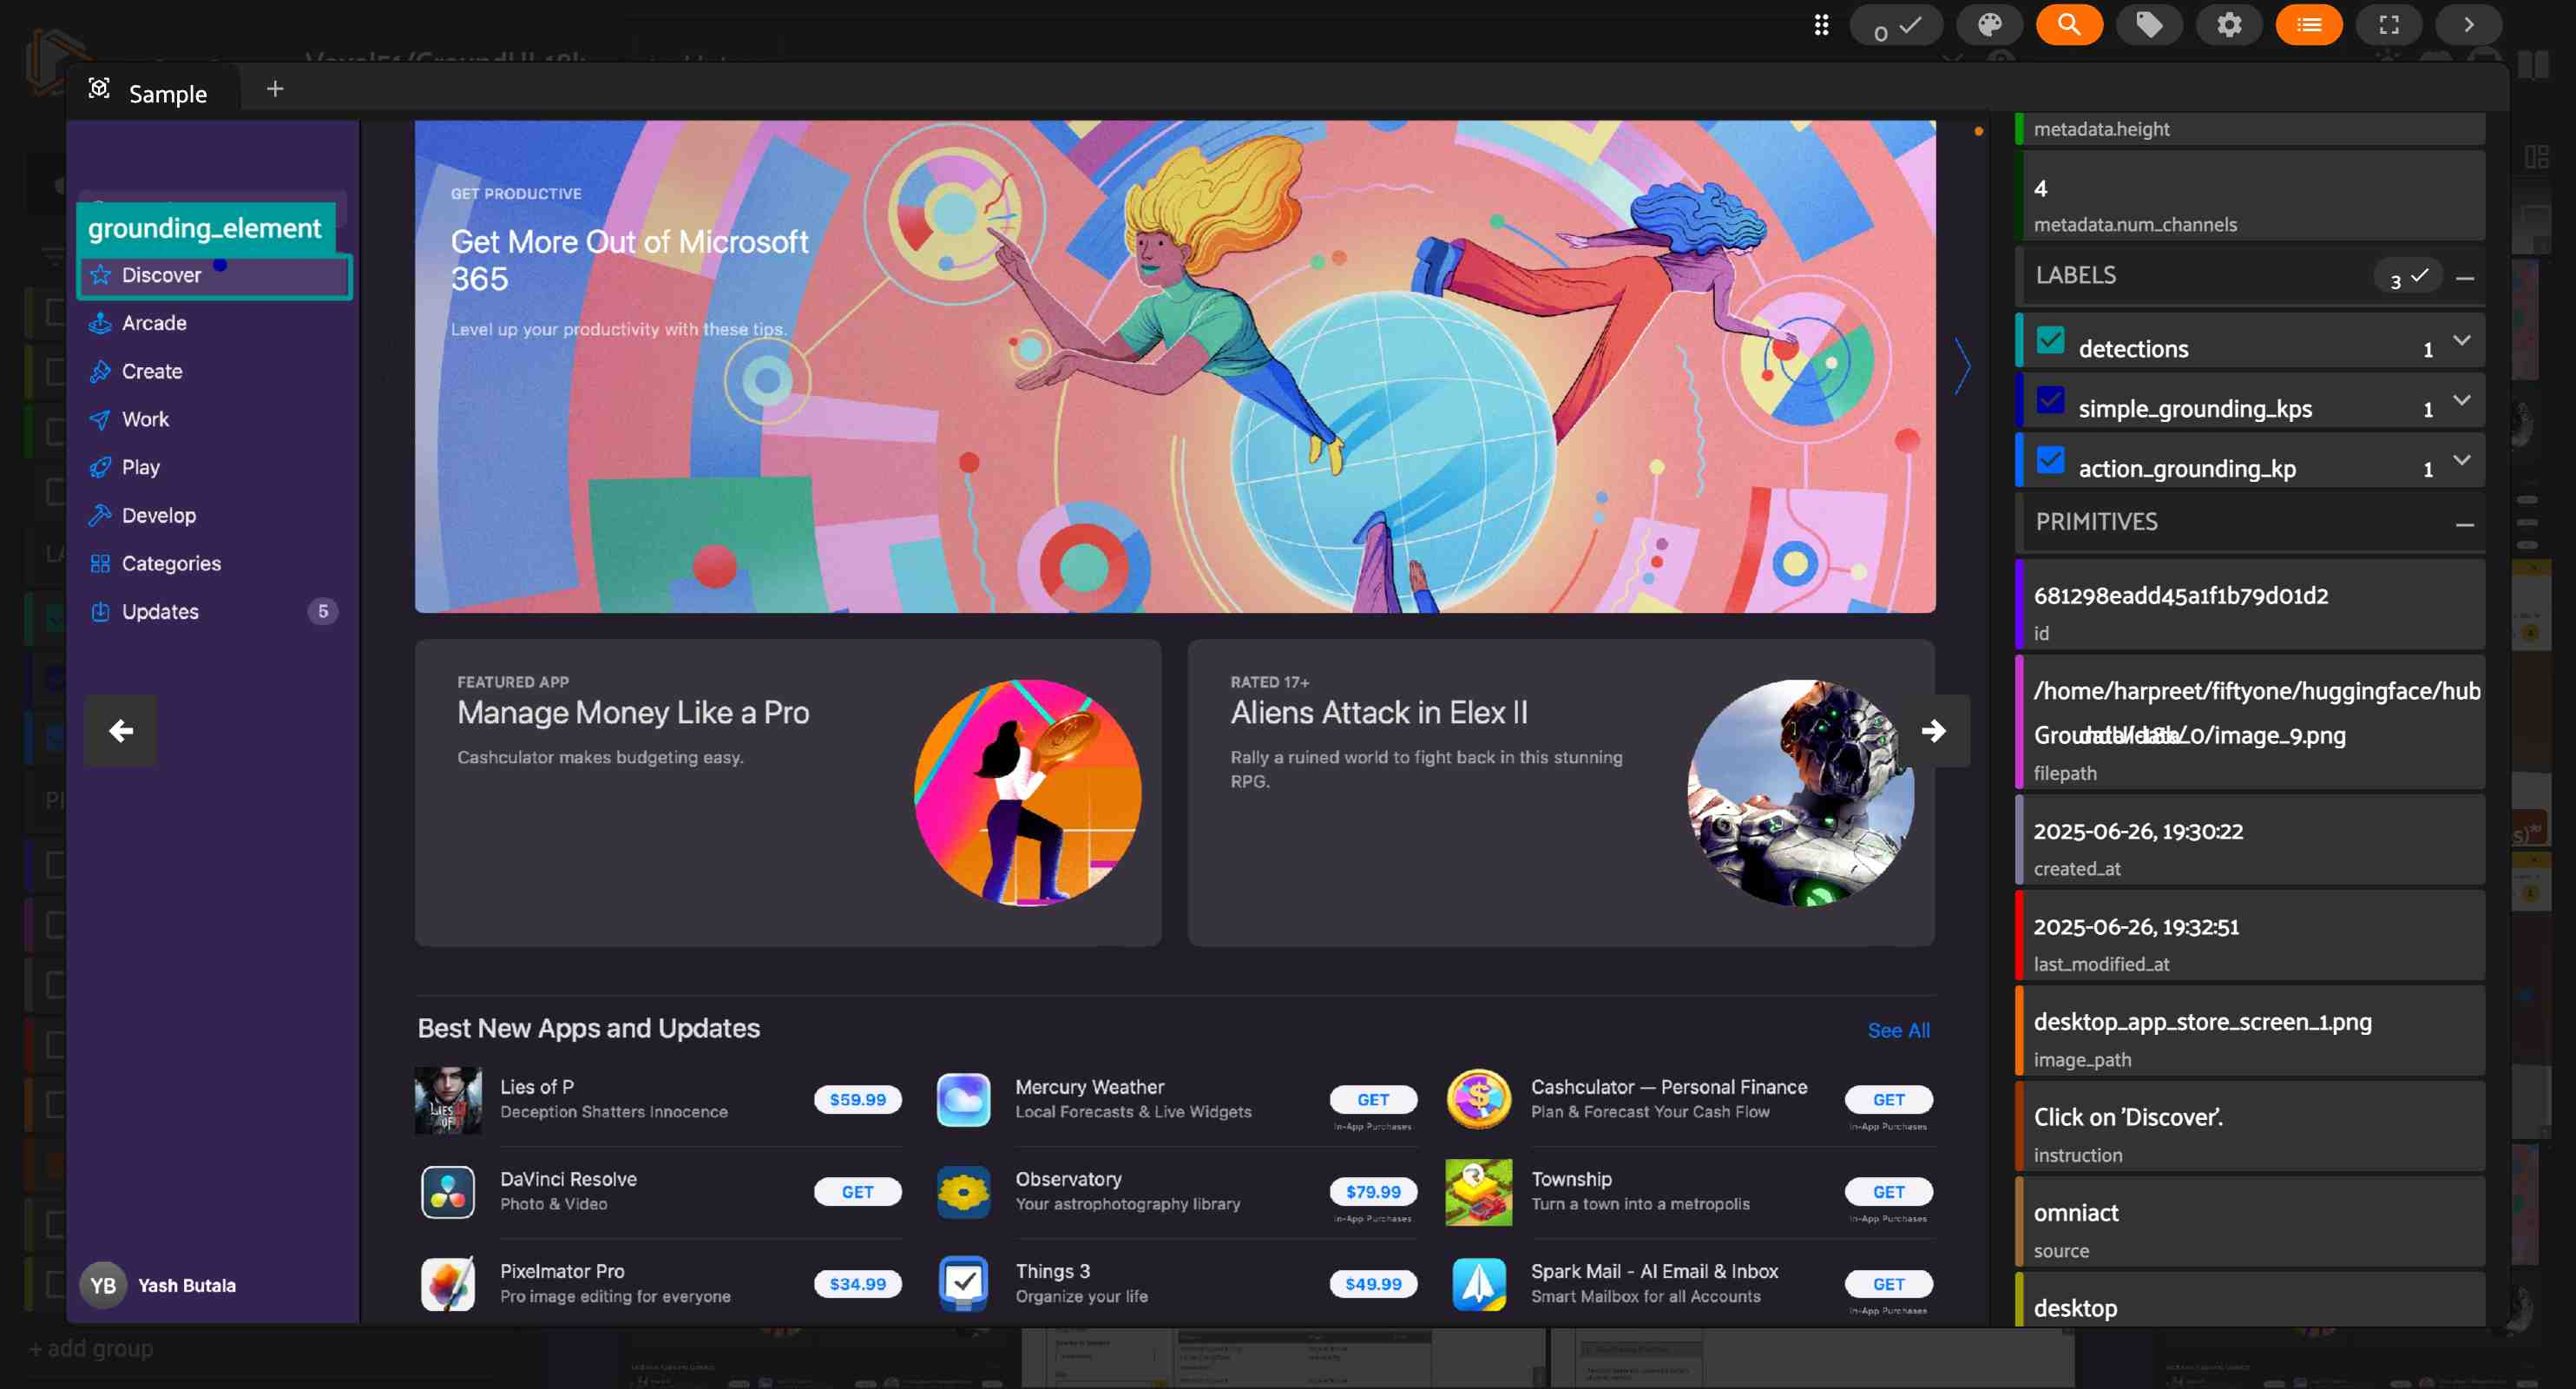

In [14]:
# Visualize all results in the FiftyOne App
session = fo.launch_app(dataset)

In [15]:
session.freeze()